In [1]:
import os
import sys
import gc
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [249]:
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

# item 군집하기

## 0. data load

In [308]:
# item = pd.read_csv('./data/Wine_Meta_final_201208.csv')
item = pd.read_csv('./data/Wine_Meta_final_201229.csv')


In [309]:
item.head()

,wine_id,name,rating_count,rating_average,label_count,review_count,type_id,body,acidity_x,alcohol,...,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51
0,1938520,1882 Cabernet Sauvignon,1697,4.1,14879,16,1,5.0,2.0,14.5,...,-3.136951,0.742006,0.173241,-1.924884,-1.610956,2.868221,-2.167123,1.151749,1.444787,2.489641
1,14604,Les Bessards Hermitage,1078,4.3,5370,3,1,5.0,3.0,14.0,...,-1.082327,0.338037,-2.199833,-0.638129,1.981586,1.148229,-0.780446,-1.026985,-3.631833,-0.124608
2,1930757,Patriarch Estate Grown,1072,4.6,6042,25,1,4.0,3.0,14.2,...,-0.657080,0.566004,0.658332,-0.343338,-1.285816,0.543290,-0.569400,1.647680,-1.445715,-0.359417
3,1564280,Merlot,3577,4.3,18748,52,1,4.0,3.0,14.4,...,2.592272,-0.271975,1.884531,0.176404,4.579372,1.793655,-4.051642,3.926317,-2.261881,-0.431446
4,2576427,Cabernet Sauvignon F Block,115,4.4,806,1,1,5.0,2.0,0.0,...,-0.016644,-0.063100,-0.098678,0.082621,0.164888,-0.078193,0.113466,0.270745,0.158934,-0.330067


## 1. data check

In [310]:
# continuous / categorical columns 구분

In [311]:
categorical_columns = [
    'type_id',
    'grapes_id',
    'region_id',
    'country_code',
    'winery_id'
]

continuous_columns = list(set(item.columns) - set(categorical_columns))

In [312]:
# 필요없는 columns
drop_columns = ['name']

In [313]:
# 중복 columns
# 해당 acidity는 meta와 taste에서 온걸로 판단됨
# acidity_x는 meta에서
# acidity_y는 taste에서..
item[item.columns[item.columns.str.contains('_x|_y')]]

,acidity_x,acidity_y
0,2.0,3.485010
1,3.0,3.429150
2,3.0,3.851015
3,3.0,1.775668
4,2.0,3.511364
...,...,...
50855,3.0,3.212859
50856,3.0,3.072673
50857,3.0,3.982508
50858,3.0,4.061172


In [314]:
# categorical columns는 어떻게 처리할까?
# type_id를 제외하고는 매우 sparse할 것으로 예상됨
item[categorical_columns].nunique()

type_id             7
grapes_id        5155
region_id        1909
country_code       54
winery_id       16666
dtype: int64

In [315]:
item['type_id'] = item['type_id'].astype(object)
pd.get_dummies(item[['type_id', 'country_code']])

,type_id_1,type_id_2,type_id_3,type_id_4,type_id_7,type_id_24,type_id_25,country_code_al,country_code_am,country_code_ar,...,country_code_se,country_code_si,country_code_sk,country_code_th,country_code_tn,country_code_tr,country_code_ua,country_code_us,country_code_uy,country_code_za
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50855,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50856,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50857,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50858,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Data preprocessing

In [316]:
# type_id와 country_code만 남겨두기
item = pd.concat([item, pd.get_dummies(item[['type_id', 'country_code']])], axis = 1)

In [317]:
# 삭제
item = item.drop(drop_columns + ['grapes_id', 'region_id', 'country_code', 'type_id', 'winery_id'], axis = 1)

In [318]:
# 군집분석을 위한 데이터 정규화

In [319]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [320]:
X = scaler.fit_transform(item.iloc[:, 1:])

In [321]:
X = pd.DataFrame(X, columns = item.columns[1:], index = item.wine_id)

In [322]:
X

,rating_count,rating_average,label_count,review_count,body,acidity_x,alcohol,winery_ratings_count,winery_ratings_average,winery_labels_count,...,country_code_se,country_code_si,country_code_sk,country_code_th,country_code_tn,country_code_tr,country_code_ua,country_code_us,country_code_uy,country_code_za
wine_id,,,,,,,,,,,,,,,,,,,,,
1938520,0.011389,0.854167,0.013071,0.000700,1.00,0.5,0.107407,0.034976,0.730769,0.030587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14604,0.007233,0.895833,0.004713,0.000131,1.00,1.0,0.103704,0.133477,0.538462,0.116206,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1930757,0.007192,0.958333,0.005303,0.001093,0.75,1.0,0.105185,0.014344,0.769231,0.012414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1564280,0.024015,0.895833,0.016471,0.002274,0.75,1.0,0.106667,0.026092,0.769231,0.020956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2576427,0.000766,0.916667,0.000701,0.000044,1.00,0.5,0.000000,0.001993,0.769231,0.001947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669561,0.005285,0.729167,0.005825,0.000394,0.50,1.0,0.000000,0.119447,0.384615,0.170013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1861275,0.001545,0.791667,0.000838,0.000262,0.50,1.0,0.100000,0.004763,0.576923,0.003197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2201892,0.002612,0.812500,0.001736,0.000612,0.00,1.0,0.000000,0.013926,0.615385,0.010739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [323]:
# taste 부분만 null을 어떻게 처리해줄지 고민해야할 듯
X.isnull().sum().sort_values().tail(50)

winery_ratings_count               105
winery_labels_count                105
oak_mentions_count                 849
oak_score                          849
oak_count                          849
earth_score                        861
earth_mentions_count               861
earth_count                        861
non_oak_mentions_count            1785
non_oak_score                     1785
non_oak_count                     1785
spices_count                      2219
spices_score                      2219
spices_mentions_count             2219
microbio_mentions_count           4008
microbio_score                    4008
microbio_count                    4008
acidity_x                         6553
body                              6553
red_fruit_score                   6625
red_fruit_count                   6625
red_fruit_mentions_count          6625
acidity_y                         6871
calculated_structure_count        6871
intensity                         6871
user_structure_count     

In [324]:
# token 제외 null 다시 확인
X[X.columns[X.columns.str.contains('score|count') == False]].isnull().sum().sort_values().tail(10)

Pork.1                        0
Poultry.1                     0
winery_ratings_average      105
acidity_x                  6553
body                       6553
intensity                  6871
acidity_y                  6871
sweetness                  8886
tannin                    18972
fizziness                 48845
dtype: int64

In [325]:
# null이 너무 많은 fizziness는 삭제
X = X.drop('fizziness', axis = 1)

In [326]:
# body와 acidity, intensity, sweetness, tannin은 회귀로 예측하는 과정을 가져보겠음

In [327]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [328]:
# 예측하고 싶은 columns 제외 모두 feature로 활용
for predict_columns in ['body', 'acidity_x', 'acidity_y', 'intensity', 'sweetness', 'tannin']:
    
    X_notnull = X.loc[X[predict_columns].notnull()] # train
    X_null = X.loc[X[predict_columns].isnull()] # predict
    
    X_notnull = X_notnull.fillna(0)
    X_notnull_train, X_notnull_test = train_test_split(X_notnull, test_size = 0.2, random_state = 42)
    
    LR = LinearRegression()
    LR.fit(X_notnull_train.drop(predict_columns, axis = 1), X_notnull_train[predict_columns])
    score = LR.score(X_notnull_test.drop(predict_columns, axis = 1), X_notnull_test[predict_columns])
    print(predict_columns, ':', score)

body : 0.7941987086052102
acidity_x : 0.43687398690300705
acidity_y : 0.7451602658930905
intensity : 0.7895928857733683
sweetness : 0.65809113636238
tannin : 0.7943300953318901


In [329]:
# body, intensity, sweetness, tannin columns 제외 모두 feature로 활용
for predict_columns in ['body', 'acidity_x', 'acidity_y', 'intensity', 'sweetness', 'tannin']:
    
    X_notnull = (X.loc[(X['body'].notnull()) &
                       (X['intensity'].notnull()) &
                       (X['sweetness'].notnull()) &
                       (X['tannin'].notnull()) &
                       (X['acidity_x'].notnull()) & 
                       (X['acidity_y'].notnull())                      
                      ]) # train
    X_null = X.loc[set(X.index) - set(X_notnull.index)] # predict
    
    X_notnull = X_notnull.fillna(0)
    X_notnull_train, X_notnull_test = train_test_split(X_notnull, test_size = 0.2, random_state = 42)
    
    LR = LinearRegression()
    LR.fit(X_notnull_train.drop(['body', 'acidity_x', 'acidity_y', 'intensity', 'sweetness', 'tannin'], axis = 1), X_notnull_train[predict_columns])
    score = LR.score(X_notnull_test.drop(['body', 'acidity_x', 'acidity_y', 'intensity', 'sweetness', 'tannin'], axis = 1), X_notnull_test[predict_columns])
    print(predict_columns, ':', score)

body : 0.7235930402457014
acidity_x : 0.5737918070307769
acidity_y : 0.4324769351676796
intensity : 0.6903688449861423
sweetness : 0.46125340497199907
tannin : 0.45425742830081794


In [331]:
# 예측하고 싶은 columns 제외 모두 feature로 활용
for predict_columns in ['body', 'acidity_x', 'acidity_y', 'intensity', 'sweetness', 'tannin']:
    
    X_notnull = X.loc[X[predict_columns].notnull()] # train
    X_null = X.loc[X[predict_columns].isnull()] # predict
    null_index = X_null.index
    
    
    X_notnull = X_notnull.fillna(0)
    X_notnull_train, X_notnull_test = train_test_split(X_notnull, test_size = 0.2, random_state = 42)
    
    LR = LinearRegression()
    LR.fit(X_notnull_train.drop(predict_columns, axis = 1), X_notnull_train[predict_columns])
    
    X_null = X_null.fillna(0)
    predict_value = LR.predict(X_null.drop(predict_columns, axis = 1))
    
    X.loc[null_index, predict_columns] = predict_value

## 3. Clustering

In [332]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 

In [333]:
X.isnull().sum().sort_values().tail(50)

acidity_y                            0
pca_5                                0
pca_6                                0
pca_7                                0
pca_4                                0
winery_ratings_count               105
winery_ratings_average             105
winery_wines_count                 105
winery_labels_count                105
oak_count                          849
oak_score                          849
oak_mentions_count                 849
earth_count                        861
earth_score                        861
earth_mentions_count               861
non_oak_count                     1785
non_oak_mentions_count            1785
non_oak_score                     1785
spices_score                      2219
spices_mentions_count             2219
spices_count                      2219
microbio_count                    4008
microbio_score                    4008
microbio_mentions_count           4008
red_fruit_mentions_count          6625
red_fruit_score          

In [334]:
X = X.fillna(0)

In [335]:
# 각 군집 수에 따른 SSE(군집내 오차제곱합)와 Silhouette score(군집간 분리도 - 군집내 응집도) 계산하여 리스트로 저장
wss = []
sis = []

for k in tqdm(range(2,10)):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(X)
    wss = np.append(wss, kmeans.inertia_)
    sis = np.append(sis, silhouette_score(X, kmeans.labels_))

100%|██████████| 8/8 [05:02<00:00, 37.87s/it]


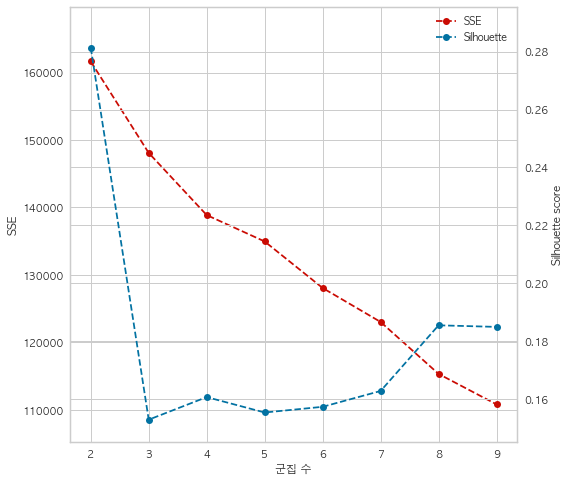

In [336]:
# 군집 수에 따른 SSE와 Silhouette score 시각화

fig, ax1 = plt.subplots(figsize = (8,8))
ax2 = ax1.twinx() # 양쪽 축을 개별로 사용

line1 = ax1.plot(np.arange(2,10), wss, 'ro--', label='SSE')
line2 = ax2.plot(np.arange(2,10), sis, 'bo--', label='Silhouette') 

ax1.set_ylim(wss.min()*0.95, wss.max()*1.05)
ax2.set_ylim(sis.min()*0.95, sis.max()*1.05)

ax1.set_xlabel('군집 수')
ax1.set_ylabel('SSE')
ax2.set_ylabel('Silhouette score')

lines = line1 + line2
labels = [l.get_label() for l in lines]

plt.legend(lines, labels)
plt.show()

In [246]:
import warnings
warnings.filterwarnings(action='ignore') # 경고창 없애기

from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer

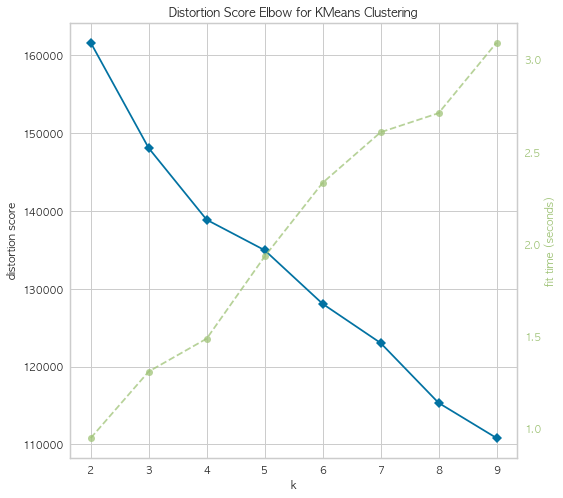

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fa3604feed0>,
                 k=None, model=None)

In [343]:
plt.figure(figsize = (8,8))
kelbow_visualizer(KMeans(random_state=0), X, k=(2,10))

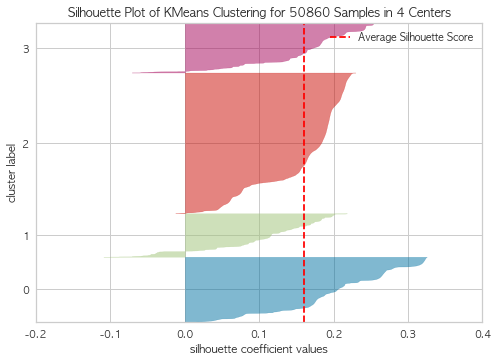

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fa331cf3210>,
                     colors='yellowbrick', model=None)

In [344]:
# 군집이 4개일 때, 실루엣 계수의 평균은 0.2
# 모든 군집이 실루엣 계수를 어느정도 초과했지만, 실루엣 계수 자체가 약간 낮음
silhouette_visualizer(KMeans(4, random_state=0), X, colors='yellowbrick')

In [347]:
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=0)

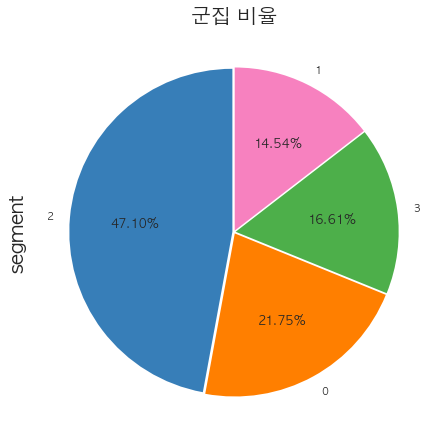

In [348]:
plt.figure(figsize=(7,7))
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf']
explode = [0.01 for j in range(best_k)]
pd.Series(kmeans.labels_).value_counts().plot.pie(autopct='%.2f%%', figsize=(6,6), startangle=90, legend=False, explode = explode, colors = colors)
plt.title("군집 비율", fontsize = 20)
plt.ylabel('segment', fontsize = 20)
plt.tight_layout(pad=0.1, h_pad=0.1)
plt.show()

## 4. making data set

In [362]:
item.index = item['wine_id']

In [381]:
# 정규화된 데이터로 예측한 데이터로 다시 한번 원 데이터를 예측하는 작업
for predict_columns in ['body', 'acidity_x', 'acidity_y', 'intensity', 'sweetness', 'tannin']:
    
    X_notnull = X.loc[item.loc[item[predict_columns].notnull()].index] # train
    X_null = X.loc[item.loc[item[predict_columns].isnull()].index] # predict
    
    X_notnull = X_notnull.fillna(0)
    X_notnull_train, X_notnull_test = train_test_split(X_notnull, test_size = 0.2, random_state = 42)
    
    LR = LinearRegression()
    LR.fit(X_notnull_train.drop(predict_columns, axis = 1), item.loc[X_notnull_train.index, predict_columns])
    score = LR.score(X_notnull_test.drop(predict_columns, axis = 1), item.loc[X_notnull_test.index, predict_columns])
    print(predict_columns, ':', score)

body : 0.7978997042681993
acidity_x : 0.4367735953038191
acidity_y : 0.8149328404623842
intensity : 0.8372547095131415
sweetness : 0.6609491992465222
tannin : 0.7943300953318903


In [382]:
# 정규화된 데이터로 예측한 데이터로 다시 한번 원 데이터를 예측하는 작업
for predict_columns in ['body', 'acidity_x', 'acidity_y', 'intensity', 'sweetness', 'tannin']:
    
    X_notnull = X.loc[item.loc[item[predict_columns].notnull()].index] # train
    X_null = X.loc[item.loc[item[predict_columns].isnull()].index] # predict
    null_index = X_null.index
    
    X_notnull = X_notnull.fillna(0)
    X_notnull_train, X_notnull_test = train_test_split(X_notnull, test_size = 0.2, random_state = 42)
    
    LR = LinearRegression()
    LR.fit(X_notnull_train.drop(predict_columns, axis = 1), item.loc[X_notnull_train.index, predict_columns])
    
    X_null = X_null.fillna(0)
    predict_value = LR.predict(X_null.drop(predict_columns, axis = 1))
    
    item.loc[null_index, predict_columns] = predict_value

In [394]:
item = item.reset_index(drop = True).fillna(0)

In [401]:
item = item.drop(list(item.columns[item.columns.str.contains('type_id|country_code_')]) + ['acidity_x'], axis = 1)

In [404]:
item.head()

,wine_id,rating_count,rating_average,label_count,review_count,body,alcohol,winery_ratings_count,winery_ratings_average,winery_labels_count,...,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51
0,1938520,1697,4.1,14879,16,5.0,14.5,18888.0,4.3,121618.0,...,-3.136951,0.742006,0.173241,-1.924884,-1.610956,2.868221,-2.167123,1.151749,1.444787,2.489641
1,14604,1078,4.3,5370,3,5.0,14.0,72079.0,3.8,462021.0,...,-1.082327,0.338037,-2.199833,-0.638129,1.981586,1.148229,-0.780446,-1.026985,-3.631833,-0.124608
2,1930757,1072,4.6,6042,25,4.0,14.2,7747.0,4.4,49362.0,...,-0.657080,0.566004,0.658332,-0.343338,-1.285816,0.543290,-0.569400,1.647680,-1.445715,-0.359417
3,1564280,3577,4.3,18748,52,4.0,14.4,14091.0,4.4,83324.0,...,2.592272,-0.271975,1.884531,0.176404,4.579372,1.793655,-4.051642,3.926317,-2.261881,-0.431446
4,2576427,115,4.4,806,1,5.0,0.0,1077.0,4.4,7749.0,...,-0.016644,-0.063100,-0.098678,0.082621,0.164888,-0.078193,0.113466,0.270745,0.158934,-0.330067


In [402]:
wine = pd.read_csv('./data/Wine_Meta_final_201229.csv')

In [405]:
add_columns = wine[drop_columns + ['grapes_id', 'region_id', 'country_code', 'type_id', 'winery_id']]
item = pd.concat([item, add_columns], axis = 1)
item['segment'] = kmeans.labels_
item

,wine_id,rating_count,rating_average,label_count,review_count,body,alcohol,winery_ratings_count,winery_ratings_average,winery_labels_count,...,pca_49,pca_50,pca_51,name,grapes_id,region_id,country_code,type_id,winery_id,segment
0,1938520,1697,4.1,14879,16,5.0,14.5,18888.0,4.3,121618.0,...,1.151749,1.444787,2.489641,1882 Cabernet Sauvignon,[2],105.0,us,1,2412.0,2
1,14604,1078,4.3,5370,3,5.0,14.0,72079.0,3.8,462021.0,...,-1.026985,-3.631833,-0.124608,Les Bessards Hermitage,[1],535.0,fr,1,7636.0,2
2,1930757,1072,4.6,6042,25,4.0,14.2,7747.0,4.4,49362.0,...,1.647680,-1.445715,-0.359417,Patriarch Estate Grown,"[2, 10]",88.0,us,1,1905.0,2
3,1564280,3577,4.3,18748,52,4.0,14.4,14091.0,4.4,83324.0,...,3.926317,-2.261881,-0.431446,Merlot,[10],24.0,us,1,1297.0,2
4,2576427,115,4.4,806,1,5.0,0.0,1077.0,4.4,7749.0,...,0.270745,0.158934,-0.330067,Cabernet Sauvignon F Block,[2],42.0,us,1,2232.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50855,1669561,788,3.5,6635,9,3.0,0.0,64503.0,3.4,675950.0,...,-2.278633,-0.337037,-2.108658,Garganega - Pinot Grigio,"[104, 34]",983.0,it,2,19962.0,1
50856,1861275,231,3.8,961,6,3.0,13.5,2573.0,3.9,12719.0,...,-0.010373,-0.298942,0.240547,Dadà Langhe Chardonnay,[5],613.0,it,2,17655.0,1
50857,2201892,390,3.9,1983,14,1.0,0.0,7521.0,4.0,42703.0,...,-0.312077,-0.135752,-0.265988,Metodo Zero Prosecco Extra Dry,[112],3232.0,it,3,13763.0,1
50858,2396179,302,4.2,730,4,4.0,13.5,2698.0,4.1,8772.0,...,-0.542009,0.079459,-0.041871,Les Monts Damnés Sancerre,[17],635.0,fr,2,58349.0,3


In [406]:
item = item[[item.columns[0]] + ['name'] + list(item.columns[item.columns.str.contains('wine_id|name') == False])]

In [407]:
item.head()

,wine_id,name,rating_count,rating_average,label_count,review_count,body,alcohol,winery_ratings_count,winery_ratings_average,...,pca_48,pca_49,pca_50,pca_51,grapes_id,region_id,country_code,type_id,winery_id,segment
0,1938520,1882 Cabernet Sauvignon,1697,4.1,14879,16,5.0,14.5,18888.0,4.3,...,-2.167123,1.151749,1.444787,2.489641,[2],105.0,us,1,2412.0,2
1,14604,Les Bessards Hermitage,1078,4.3,5370,3,5.0,14.0,72079.0,3.8,...,-0.780446,-1.026985,-3.631833,-0.124608,[1],535.0,fr,1,7636.0,2
2,1930757,Patriarch Estate Grown,1072,4.6,6042,25,4.0,14.2,7747.0,4.4,...,-0.569400,1.647680,-1.445715,-0.359417,"[2, 10]",88.0,us,1,1905.0,2
3,1564280,Merlot,3577,4.3,18748,52,4.0,14.4,14091.0,4.4,...,-4.051642,3.926317,-2.261881,-0.431446,[10],24.0,us,1,1297.0,2
4,2576427,Cabernet Sauvignon F Block,115,4.4,806,1,5.0,0.0,1077.0,4.4,...,0.113466,0.270745,0.158934,-0.330067,[2],42.0,us,1,2232.0,2


In [409]:
item.isnull().sum().sort_values()

wine_id           0
pca_2             0
pca_3             0
pca_4             0
pca_5             0
               ... 
segment           0
winery_id       105
region_id       123
country_code    123
grapes_id       489
Length: 152, dtype: int64

In [412]:
item[['winery_id', 'region_id', 'country_code', 'grapes_id']]

,winery_id,region_id,country_code,grapes_id
0,2412.0,105.0,us,[2]
1,7636.0,535.0,fr,[1]
2,1905.0,88.0,us,"[2, 10]"
3,1297.0,24.0,us,[10]
4,2232.0,42.0,us,[2]
...,...,...,...,...
50855,19962.0,983.0,it,"[104, 34]"
50856,17655.0,613.0,it,[5]
50857,13763.0,3232.0,it,[112]
50858,58349.0,635.0,fr,[17]


In [414]:
for column, value in zip(['winery_id', 'region_id', 'country_code', 'grapes_id'], [0, 0, 'unk', [0]]):
    item.loc[item[column].isnull(), column] = value

In [415]:
item.isnull().sum().sort_values()

wine_id                        0
pca_3                          0
pca_4                          0
pca_5                          0
pca_6                          0
                              ..
citrus_fruit_count             0
citrus_fruit_score             0
citrus_fruit_mentions_count    0
Vegetarian.1                   0
segment                        0
Length: 152, dtype: int64

In [416]:
item

,wine_id,name,rating_count,rating_average,label_count,review_count,body,alcohol,winery_ratings_count,winery_ratings_average,...,pca_48,pca_49,pca_50,pca_51,grapes_id,region_id,country_code,type_id,winery_id,segment
0,1938520,1882 Cabernet Sauvignon,1697,4.1,14879,16,5.0,14.5,18888.0,4.3,...,-2.167123,1.151749,1.444787,2.489641,[2],105.0,us,1,2412.0,2
1,14604,Les Bessards Hermitage,1078,4.3,5370,3,5.0,14.0,72079.0,3.8,...,-0.780446,-1.026985,-3.631833,-0.124608,[1],535.0,fr,1,7636.0,2
2,1930757,Patriarch Estate Grown,1072,4.6,6042,25,4.0,14.2,7747.0,4.4,...,-0.569400,1.647680,-1.445715,-0.359417,"[2, 10]",88.0,us,1,1905.0,2
3,1564280,Merlot,3577,4.3,18748,52,4.0,14.4,14091.0,4.4,...,-4.051642,3.926317,-2.261881,-0.431446,[10],24.0,us,1,1297.0,2
4,2576427,Cabernet Sauvignon F Block,115,4.4,806,1,5.0,0.0,1077.0,4.4,...,0.113466,0.270745,0.158934,-0.330067,[2],42.0,us,1,2232.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50855,1669561,Garganega - Pinot Grigio,788,3.5,6635,9,3.0,0.0,64503.0,3.4,...,-2.457316,-2.278633,-0.337037,-2.108658,"[104, 34]",983.0,it,2,19962.0,1
50856,1861275,Dadà Langhe Chardonnay,231,3.8,961,6,3.0,13.5,2573.0,3.9,...,0.212103,-0.010373,-0.298942,0.240547,[5],613.0,it,2,17655.0,1
50857,2201892,Metodo Zero Prosecco Extra Dry,390,3.9,1983,14,1.0,0.0,7521.0,4.0,...,-0.267864,-0.312077,-0.135752,-0.265988,[112],3232.0,it,3,13763.0,1
50858,2396179,Les Monts Damnés Sancerre,302,4.2,730,4,4.0,13.5,2698.0,4.1,...,-2.494865,-0.542009,0.079459,-0.041871,[17],635.0,fr,2,58349.0,3


In [428]:
X['segment'] = kmeans.labels_

In [429]:
X.to_csv('./data/Wine_segment_scaled_201231.csv', index = False)

In [417]:
item.to_csv('./data/Wine_segment_201229.csv', index = False)